## Анализ экономического развития и его связи с другими показателями 
 
Автор: Зайцев Виталий  
Данные взяты с https://datahelpdesk.worldbank.org/knowledgebase

**Цель анализа**

**Проверить гипотезы:**
- **Ключевая гипотеза**: существует ли корреляция между уровнем экономического развития страны (ВВП на душу населения) и уровнем человеческого развития (доступ к электричеству, уровень образования и так далее), и как эта зависимость менялась с течением времени для разных групп стран (по уровню дохода / континенту и так далее)?
- **Альтернативная гипотеза**: как связаны между собой экономический рост, потребление ресурсов (электроэнергия) и социальный прогресс (образование, урбанизация)

### Индикаторы для анализа

**Экономика**
- ВВП
- ВВП на душу населения

**Образование и наука**
- Госрасходы на образование (% ВВП)
- Количество научных публикаций
- Количество научных публикаций на душу населения (рассчитанный показатель)

**Здравоохранение**
- Расходы на здравоохранение (% ВВП)
- Детская смертность (на 1000 рождений)

**Технологии и инновации**
- Пользователи интернета (% населения)

**Инфраструктура**
- Доступ к электричеству (% населения)
- Использование энергии на душу населения
    
**Популяция**
- Численность населения
- Численность городского населения

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
from scipy.stats import zscore
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

### Этап 1. Загрузка и подготовка данных

In [2]:
load_dotenv('wb.env')

# создаю подключение к базе данных
try:
    connection_string = (
        f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASS')}"
        f"@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
    )
    engine = create_engine(connection_string, connect_args={'sslmode': 'require'}) # аргументы для Supabase

    with engine.connect() as conn:
        conn.execute(text("SELECT 1"))
    print("Подключение удачно")
except Exception as e:
    print(f"Ошибка подключения к Supabase: {e}")
    

Подключение удачно


In [3]:
# загружаю из пердставления в базе данных таблицу агрегированных регионов, показателей и значений в датафрейм
query_2 = text("SELECT * FROM aggregate_countries")
df_agg_countries = pd.read_sql(query_2, engine)

In [4]:
df_agg_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22283 entries, 0 to 22282
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    22283 non-null  object 
 1   indicator  22283 non-null  object 
 2   year       22283 non-null  int64  
 3   value      22283 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 696.5+ KB


In [5]:
# список индикаторов, которые не войдут в анализ корреляции
extra_indicators = ['GDP (current US$)', 'Scientific and technical journal articles', 'Population, total']

In [6]:
# разбиваю данные на два датафрейма - по географии и по доходу
geographic_regions = [
    'East Asia & Pacific',
    'Europe & Central Asia', 
    'Latin America & Caribbean',
    'Middle East, North Africa, Afghanistan & Pakistan',
    'North America',
    'South Asia',
    'Sub-Saharan Africa',
    'Arab World'
]

income_categories = [
    'High income',
    'Upper middle income',
    'Middle income',
    'Lower middle income', 
    'Low income'
]
# фильтрую по географии
df_geographic_regions = df_agg_countries[df_agg_countries['country'].isin(geographic_regions)]
# убираю не нужные индикаторы
df_geographic_regions = df_geographic_regions[~df_geographic_regions['indicator'].isin(extra_indicators)]
print('Случайные 5 строк из таблицы df_geographic_regions:')
display(df_geographic_regions.sample(5))
# фильтрую по уровню богатсва
df_income_categories = df_agg_countries[df_agg_countries['country'].isin(income_categories)]
# убираю не нужные индикаторы
df_income_categories = df_income_categories[~df_income_categories['indicator'].isin(extra_indicators)]
print('Случайные 5 строк из таблицы df_income_categories:')
display(df_income_categories.sample(5))

Случайные 5 строк из таблицы df_geographic_regions:


country  \
20483  Middle East, North Africa, Afghanistan & Pakistan   
17991                                      North America   
9279                                          Arab World   
19827                              Europe & Central Asia   
18471                              Europe & Central Asia   

                                              indicator  year        value  
20483      Energy use (kg of oil equivalent per capita)  2009  1485.470000  
17991  Individuals using the Internet (% of population)  2021     0.915000  
9279           Urban population (% of total population)  1979     0.434092  
19827      Energy use (kg of oil equivalent per capita)  1997  3168.090000  
18471           Access to electricity (% of population)  1996     0.999706

Случайные 5 строк из таблицы df_income_categories:


country                                        indicator  year  \
5083   Middle income                     GDP per capita (current US$)  1985   
10171    High income         Urban population (% of total population)  1997   
11279  Middle income         Urban population (% of total population)  1994   
17007  Middle income  Mortality rate, under-5 (per 1,000 live births)  2014   
10202    High income         Urban population (% of total population)  1966   

            value  
5083   665.277000  
10171    0.751220  
11279    0.367502  
17007   42.454200  
10202    0.648010

In [7]:
# загружаю из пердставления в базе данных таблицу стран, показателей и значений в датафрейм
query = text("SELECT * FROM all_countries")
df = pd.read_sql(query, engine)

# убираю не нужные индикаторы
df_all_country = df[~df['indicator'].isin(extra_indicators)]
df_all_country.sample(5)
display(df_all_country.head())
df_all_country.info()

country                     indicator  year    value country_id  \
11549  Afghanistan  GDP per capita (current US$)  2023  413.758        AFG   
11550  Afghanistan  GDP per capita (current US$)  2022  357.261        AFG   
11551  Afghanistan  GDP per capita (current US$)  2021  356.496        AFG   
11552  Afghanistan  GDP per capita (current US$)  2020  510.787        AFG   
11553  Afghanistan  GDP per capita (current US$)  2019  496.603        AFG   

      income_level_name  
11549        Low income  
11550        Low income  
11551        Low income  
11552        Low income  
11553        Low income

<class 'pandas.core.frame.DataFrame'>
Index: 69634 entries, 11549 to 100576
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            69634 non-null  object 
 1   indicator          69634 non-null  object 
 2   year               69634 non-null  int64  
 3   value              69634 non-null  float64
 4   country_id         69634 non-null  object 
 5   income_level_name  69634 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 3.7+ MB


### Этап 2. Сводные таблицы и описательная статистика.

#### 2.1 Статистика

In [8]:
# посчитаем статистики ВВП на душу населения для всех стран и для категорий по уровню дохода
all_countries_stats = df_all_country[df_all_country['indicator'] == 'GDP per capita (current US$)'].groupby('country')['value'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).reset_index()
incom_countries_stats = df_income_categories[df_income_categories['indicator'] == 'GDP per capita (current US$)'].groupby('country',
                                                                                    as_index=False)['value'].agg([
    'mean', 'median', 'std', 'min', 'max'
    ])

In [9]:
print('Статистика ВВП на душу населения некоторых страх:')
display(all_countries_stats.sample(5))
print('\nСтатистика ВВП на душу населения стран по категории Уровень дохода:')
display(incom_countries_stats.sort_values('mean', ascending=False))        

Статистика ВВП на душу населения некоторых страх:


country         mean    median          std      min       max
59   Equatorial Guinea  3919.605180   368.831  5455.999173  121.125  18210.60
166         Seychelles  6939.608708  6520.490  6032.316118  270.280  19141.50
160              Samoa  1978.325036  1419.360  1494.599296  321.997   4898.77
76             Grenada  5228.421417  4829.670  3232.684932  736.927  11871.60
25            Botswana  3109.108548  2929.430  2706.340643   58.918   8328.71


Статистика ВВП на душу населения стран по категории Уровень дохода:


country          mean     median           std       min  \
0          High income  19563.053077  18452.700  15215.531101  1204.070   
4  Upper middle income   2837.592077   1158.960   3273.252092   142.590   
3        Middle income   1811.639400    827.024   1958.367262   127.983   
2  Lower middle income    786.444154    449.551    735.386315   104.412   
1           Low income    456.445448    387.350    204.033984   126.317   

        max  
0  50443.90  
4  10961.80  
3   6524.26  
2   2517.63  
1    868.53

In [10]:
# посчитаем статистики по доступу к электроэнергии на душу населения для всех стран и для категорий по уровню дохода
all_countries_stats_energy = df_all_country[df_all_country['indicator'] == 'Access to electricity (% of population)'].groupby('country')['value'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).reset_index()
incom_countries_stats_energy = df_income_categories[df_income_categories['indicator'] == 'Access to electricity (% of population)'].groupby('country',
                                                                                    as_index=False)['value'].agg([
    'mean', 'median', 'std', 'min', 'max'
    ])
print('Статистика по доступу к электричества на душу населения некоторых страх:')
display(all_countries_stats_energy.sample(5))
print('\nСтатистика по доступу к электричества на душу населения по категории Уровень дохода:')
display(incom_countries_stats_energy.sort_values('mean', ascending=False))

Статистика по доступу к электричества на душу населения некоторых страх:


country      mean  median       std    min  max
196                    Tunisia  0.975667  0.9945  0.037416  0.868  1.0
45                  Costa Rica  0.992458  0.9940  0.006795  0.969  1.0
10                     Austria  1.000000  1.0000  0.000000  1.000  1.0
171  Sint Maarten (Dutch part)  0.999382  1.0000  0.001129  0.997  1.0
1                      Albania  0.998147  1.0000  0.002560  0.994  1.0


Статистика по доступу к электричества на душу населения по категории Уровень дохода:


country      mean    median       std       min       max
0          High income  0.997802  0.998654  0.001827  0.994413  0.999884
4  Upper middle income  0.977661  0.985332  0.016835  0.943602  0.995089
3        Middle income  0.865850  0.866822  0.059393  0.772242  0.951584
2  Lower middle income  0.697361  0.698332  0.140885  0.471086  0.912681
1           Low income  0.300528  0.288720  0.091399  0.166319  0.452722

#### 2.2 Сводная таблица

Делаю сводную таблицу, показывающую средний ВВП на душу населения и средний уровень доступа к электричеству по регионам мира.

In [11]:
selected_ind = ['GDP per capita (current US$)', 'Access to electricity (% of population)']
# фильтрую данные по выбранным показателям
df_filtered = df_geographic_regions[df_geographic_regions['indicator'].isin(selected_ind)]
# смотрим, какой максимальный год есть у показателей и регионов
display(df_filtered.groupby(['country','indicator'])['year'].max())

country                                            indicator                              
Arab World                                         Access to electricity (% of population)    2023
                                                   GDP per capita (current US$)               2024
East Asia & Pacific                                Access to electricity (% of population)    2023
                                                   GDP per capita (current US$)               2024
Europe & Central Asia                              Access to electricity (% of population)    2023
                                                   GDP per capita (current US$)               2024
Latin America & Caribbean                          Access to electricity (% of population)    2023
                                                   GDP per capita (current US$)               2024
Middle East, North Africa, Afghanistan & Pakistan  Access to electricity (% of population)    2023
                  

Для ВВП и Доступа к экектричеству максимальный общий год - 2023, буду строить сводную таблицу по этому году.

In [12]:
# делаю сводную таблицу по среднему значению трех индикаторов и выбранным ранее регионам за 2023г.
geo_regions_pt = df_filtered.pivot_table(
    index=['country', 'year'],
    columns='indicator',
    values='value'
)
# беру данные за 2023 год
result_2023 = geo_regions_pt.xs(2023, level='year')
result_2023

indicator                                          Access to electricity (% of population)  \
country                                                                                      
Arab World                                                                        0.916454   
East Asia & Pacific                                                               0.984045   
Europe & Central Asia                                                             1.000000   
Latin America & Caribbean                                                         0.984226   
Middle East, North Africa, Afghanistan & Pakistan                                 0.964226   
North America                                                                     1.000000   
South Asia                                                                        0.994088   
Sub-Saharan Africa                                                                0.532563   

indicator                                          GDP per capita (current US$)  
country                                                                          
Arab World                                                              7479.69  
East Asia & Pacific                                                    13117.90  
Europe & Central Asia                                                  29835.70  
Latin America & Caribbean                                              10838.80  
Middle East, North Africa, Afghanistan & Pakistan                       6063.05  
North America                                                          79326.90  
South Asia                                                              2532.38  
Sub-Saharan Africa                                                      1544.76

В 2023 году наибольший ВВП на душу населения - в Северной Америке, наименьший - в странах Африки, южнее Сахары.

Большинство регионов мира имеют близкий или равнй 100% доступ населения к элкетричеству, только у стран Африки (южнее Сахары) - 53% населения имеют доступ к электричеству.

#### 2.3 Анализ распределения

Посмотрим распределения и выбросы 3 основных показателей:
- ВВП на душу населения
- Доступ к электричеству, % от населения
- Затраты на образование, % от ВВП

Анализ проведу по 3 годам: 1990, 2005 и 2023

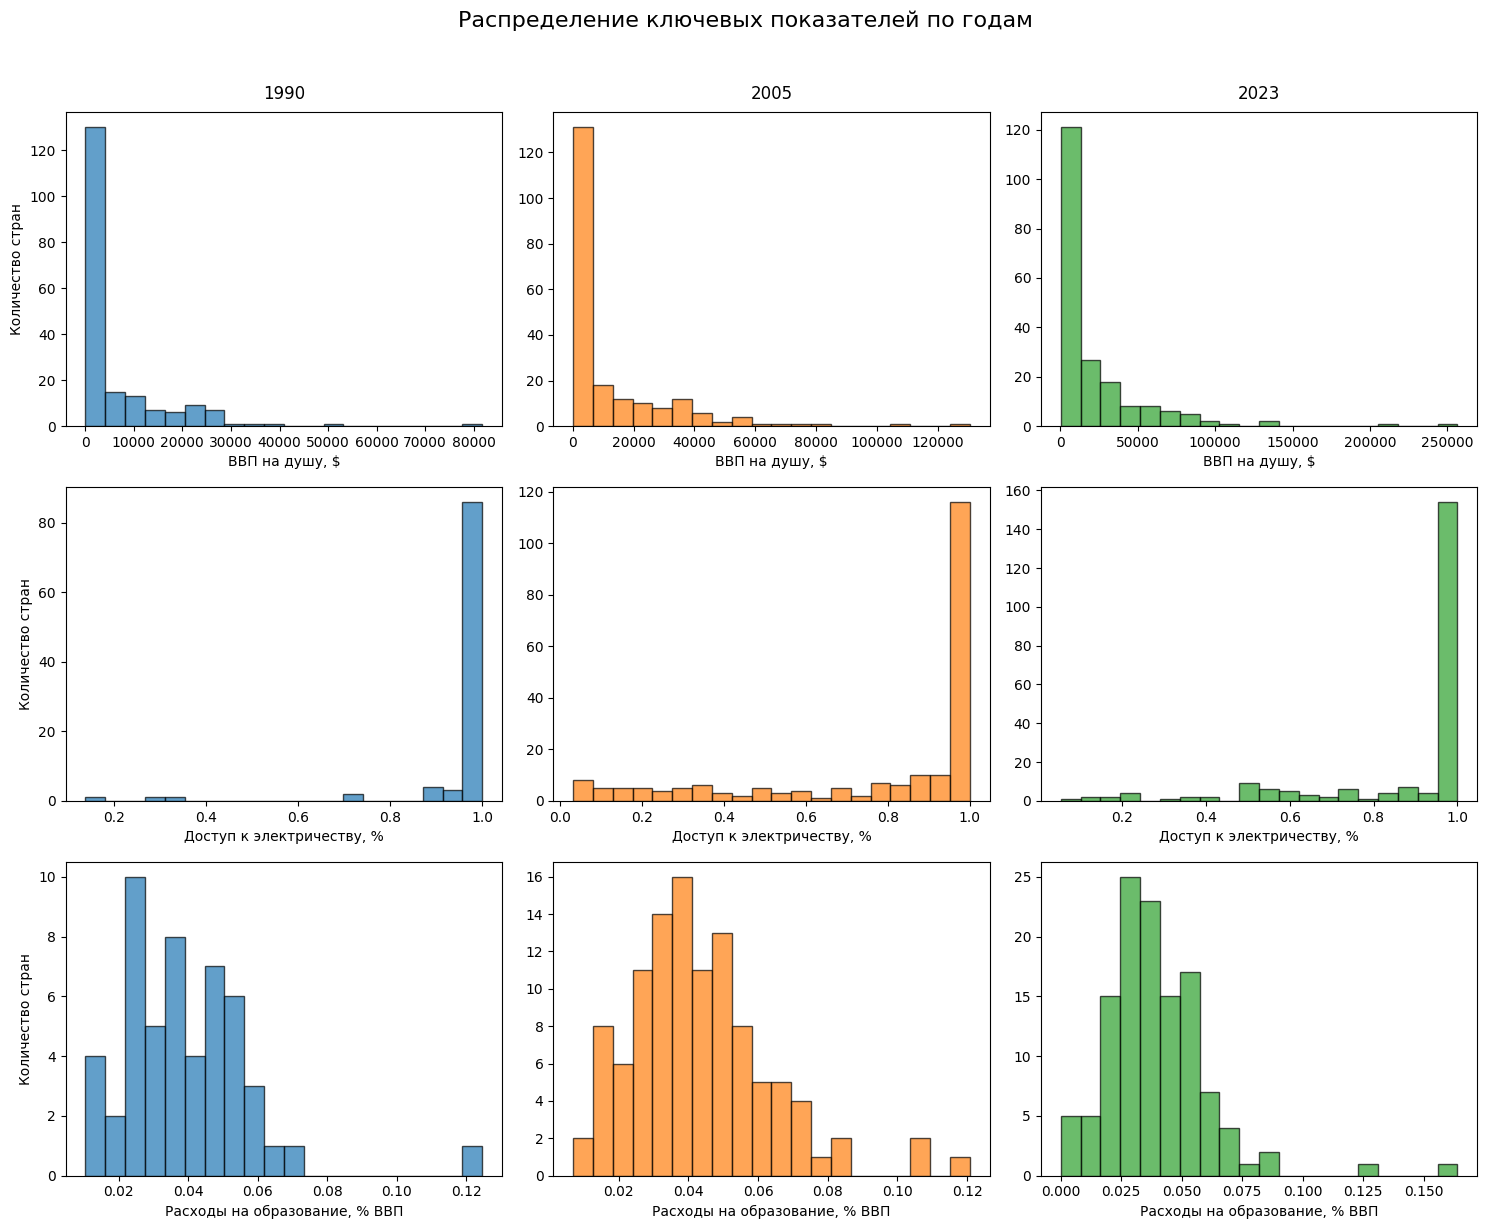

In [13]:
# Индикаторы для анализа
indicators = [
    'GDP per capita (current US$)',
    'Access to electricity (% of population)',
    'Government expenditure on education, total (% of GDP)'
]

# Годы для анализа
years = [1990, 2005, 2023]

# Создаем сетку графиков: 3 строки (по индикатору) × 3 столбца (по году)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Распределение ключевых показателей по годам', fontsize=16, y=1.02)

# Цикл по индикаторам (строкам)
for i, indicator in enumerate(indicators):
    # Цикл по годам (столбцам)
    for j, year in enumerate(years):
        ax = axes[i, j]  # текущая ось
        
        # Фильтруем данные для конкретного индикатора и года
        data = df_all_country[
            (df_all_country['indicator'] == indicator) & 
            (df_all_country['year'] == year)
        ]['value'].dropna()
        
        if len(data) > 0:
            # Строим гистограмму
            ax.hist(data, bins=20, edgecolor='black', alpha=0.7, color=f'C{j}')
            
        else:
            ax.text(0.5, 0.5, 'Нет данных', transform=ax.transAxes,
                   ha='center', va='center', fontsize=12)
        
        # Настройка заголовков и подписей осей
        if i == 0:  # только для верхнего ряда
            ax.set_title(f'{year}', fontsize=12, pad=10)
        
        if j == 0:  # только для левого столбца
            ax.set_ylabel('Количество стран', fontsize=10)
               
        if indicator == 'GDP per capita (current US$)':
            ax.set_xlabel('ВВП на душу, $', fontsize=10)
        elif indicator == 'Access to electricity (% of population)':
            ax.set_xlabel('Доступ к электричеству, %', fontsize=10)
        else:
            ax.set_xlabel('Расходы на образование, % ВВП', fontsize=10)

# Настраиваем отступы между графиками
plt.tight_layout()

plt.show()


**ВВП на душу населения**
- 1990 - больше всего стран имеют ВВП до 3000\$ на человека
- 2005 - больше всего стран имеют ВВП до 6000\$ на человека - рост в 2 раза за 15 лет
- 2023 - больше всего стран имеют ВВП до 12000\$ на человека - рост в 2 раза за 18 лет (с 2005)

Также видно некоторые выбросы в правой части распределений - это маленькие страны с высоким ВВП, такие как Манако, Лихтенштейн.

**Доступ к электричеству**
- 1990 - более 80 стран почти достигли или достигли 100% доступа населения к электричетву
- 2005 - около 120 стран почти достигли или достигли 100% доступа населения к электричетву
- 2023 - более 150 стран почти достигли или достигли 100% доступа населения к электричетву

Если сравнивать левые хвосты распределений за 2005 и 2023, то видно, что в 2023 есть сдвиг вправо, т.е. больше стран стало с более высоким уровнем доступа населения к элкетричеству.

**Расходы на образование**
Распределения имеют почти нормальную форму с правым хвостом.
- 1990 - максимум распределения в районе 2-2,5% ВВП
- 2005 - максимум распределения в районе 4% ВВП
- 2023 - максимум распределения в районе 2,5-3% ВВП

Видно, что к 2023 году в среднем расходы стран на образование снизились, по сравнению с 2005 годом.


ВВП на душу населения:
  1990: медиана = 1629.7$, n = 192, min = 53.1$, max = 81734.9$
  2005: медиана = 3577.4$, n = 209, min = 147.2$, max = 130539.0$
  2023: медиана = 7892.1$, n = 200, min = 192.1$, max = 256581.0$

Доступ к электричеству:
  1990: медиана = 100.0%, n = 98, min = 13.9%, max = 100.0%
  2005: медиана = 97.0%, n = 212, min = 3.2%, max = 100.0%
  2023: медиана = 100.0%, n = 215, min = 5.4%, max = 100.0%

Расходы на образование:
  1990: медиана = 3.6%, n = 52, min = 1.0%, max = 12.5%
  2005: медиана = 4.1%, n = 109, min = 0.7%, max = 12.1%
  2023: медиана = 3.7%, n = 121, min = 0.0%, max = 16.4%


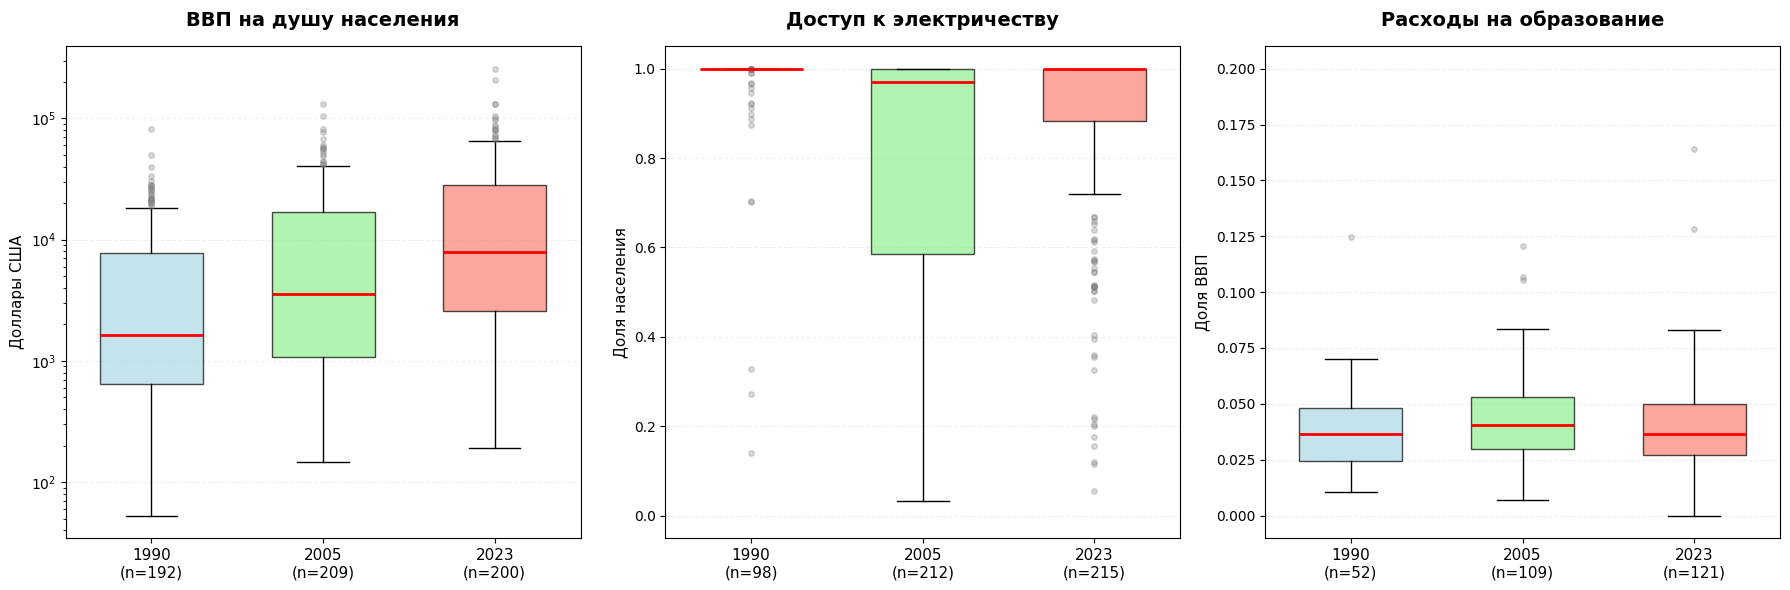

In [14]:
# Индикаторы и годы
indicators = [
    'GDP per capita (current US$)',
    'Access to electricity (% of population)',
    'Government expenditure on education, total (% of GDP)'
]

years = [1990, 2005, 2023]

# Создаем сетку графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Русские названия и единицы измерения
plot_config = {
    'GDP per capita (current US$)': {
        'title': 'ВВП на душу населения',
        'ylabel': 'Доллары США',
        'scale': 'log',  # логарифмическая шкала
        'is_percent': False
    },
    'Access to electricity (% of population)': {
        'title': 'Доступ к электричеству',
        'ylabel': 'Доля населения',  # или "Процент населения", если умножим на 100
        'scale': 'linear',
        'is_percent': True,
        'ylim': (-0.05, 1.05)  # доли от 0 до 1
    },
    'Government expenditure on education, total (% of GDP)': {
        'title': 'Расходы на образование',
        'ylabel': 'Доля ВВП',
        'scale': 'linear',
        'is_percent': True,
        'ylim': (-0.01, 0.21)  # доли от 0 до 0.2 (20%)
    }
}

# Цикл по индикаторам
for i, indicator in enumerate(indicators):
    ax = axes[i]
    config = plot_config[indicator]
    
    # Собираем данные для трех лет
    box_data = []
    year_counts = []
    
    for year in years:
        data = df[
            (df['indicator'] == indicator) & 
            (df['year'] == year)
        ]['value'].dropna().values
        
        if len(data) > 0:
            box_data.append(data)
            year_counts.append(len(data))
        else:
            box_data.append([])
            year_counts.append(0)
    
    # Создаем boxplot
    boxplots = ax.boxplot(box_data, patch_artist=True, tick_labels=years, 
                          widths=0.6, showfliers=True, 
                          medianprops={'color': 'red', 'linewidth': 2})
    
    # Раскрашиваем ящики
    colors = ['lightblue', 'lightgreen', 'salmon']
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Настраиваем выбросы
    for flier in boxplots['fliers']:
        flier.set(marker='o', markersize=4, alpha=0.3, 
                 markerfacecolor='gray', markeredgecolor='gray')
    
    # Заголовок и подписи
    ax.set_title(config['title'], fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel(config['ylabel'], fontsize=11)
    
    # Настройка шкалы
    if config['scale'] == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        if 'ylim' in config:
            ax.set_ylim(config['ylim'])
    
    # Сетка
    ax.grid(True, axis='y', alpha=0.2, linestyle='--')
    
    # Форматированные подписи под графиками
    tick_labels = []
    for idx, year in enumerate(years):
        if year_counts[idx] > 0:
            tick_labels.append(f'{year}\n(n={year_counts[idx]})')
        else:
            tick_labels.append(f'{year}\n(нет данных)')
    
    ax.set_xticklabels(tick_labels, fontsize=11)
    
    # Форматирование значений для вывода в консоль
    print(f"\n{config['title']}:")
    for idx, year in enumerate(years):
        if year_counts[idx] > 0:
            data = box_data[idx]
            if config['is_percent']:
                # Выводим в процентах для читаемости, хотя данные в долях
                print(f"  {year}: медиана = {np.median(data)*100:.1f}%, "
                      f"n = {year_counts[idx]}, "
                      f"min = {np.min(data)*100:.1f}%, max = {np.max(data)*100:.1f}%")
            else:
                print(f"  {year}: медиана = {np.median(data):.1f}$, "
                      f"n = {year_counts[idx]}, "
                      f"min = {np.min(data):.1f}$, max = {np.max(data):.1f}$")

plt.tight_layout()
plt.show()

**ВВП на душу населения**  

Виден стабильный рост ВВП - растут медианы и IQR, а также растут "усы" и верхние выбросы.

**Доступ к электричеству**

1990 - данных по этому показателю мало, поэтому "ящик с усами" получился не репрезентативным.

За 2005 и 2023 видим динамику - медиана выросла, достигнув 100% в 2023, нижний квартиль тоже вырос. И те значения, которые в 2005 году входили в 1,5 IQR, в 2023г. уже считаются выбросами. Это говорит о положительной динамике по всему миру к росту доступа населения к электричеству.

**Затраты на образование**

Видно, что в 2005 году выросли затраты на образование по сравнению с 1990г.

В 2023 году видим снижение затрат на образование по сравнению с 2005г.

---

### Этап 3. Визуализация трендов и паттернов

#### 3.1 Динамика ВВП, доступа к элкетричеству и урбанизации

Графики ниже отображают динамику ВВП, доступа к электричеству и доли городского населения в таких странах как:
- США
- Китай
- Индия
- Бразилия
- Нигерия
- Германия
- Япония

Данные показаны за все года, для которых есть значения выбранных показателей для выбранных стран.

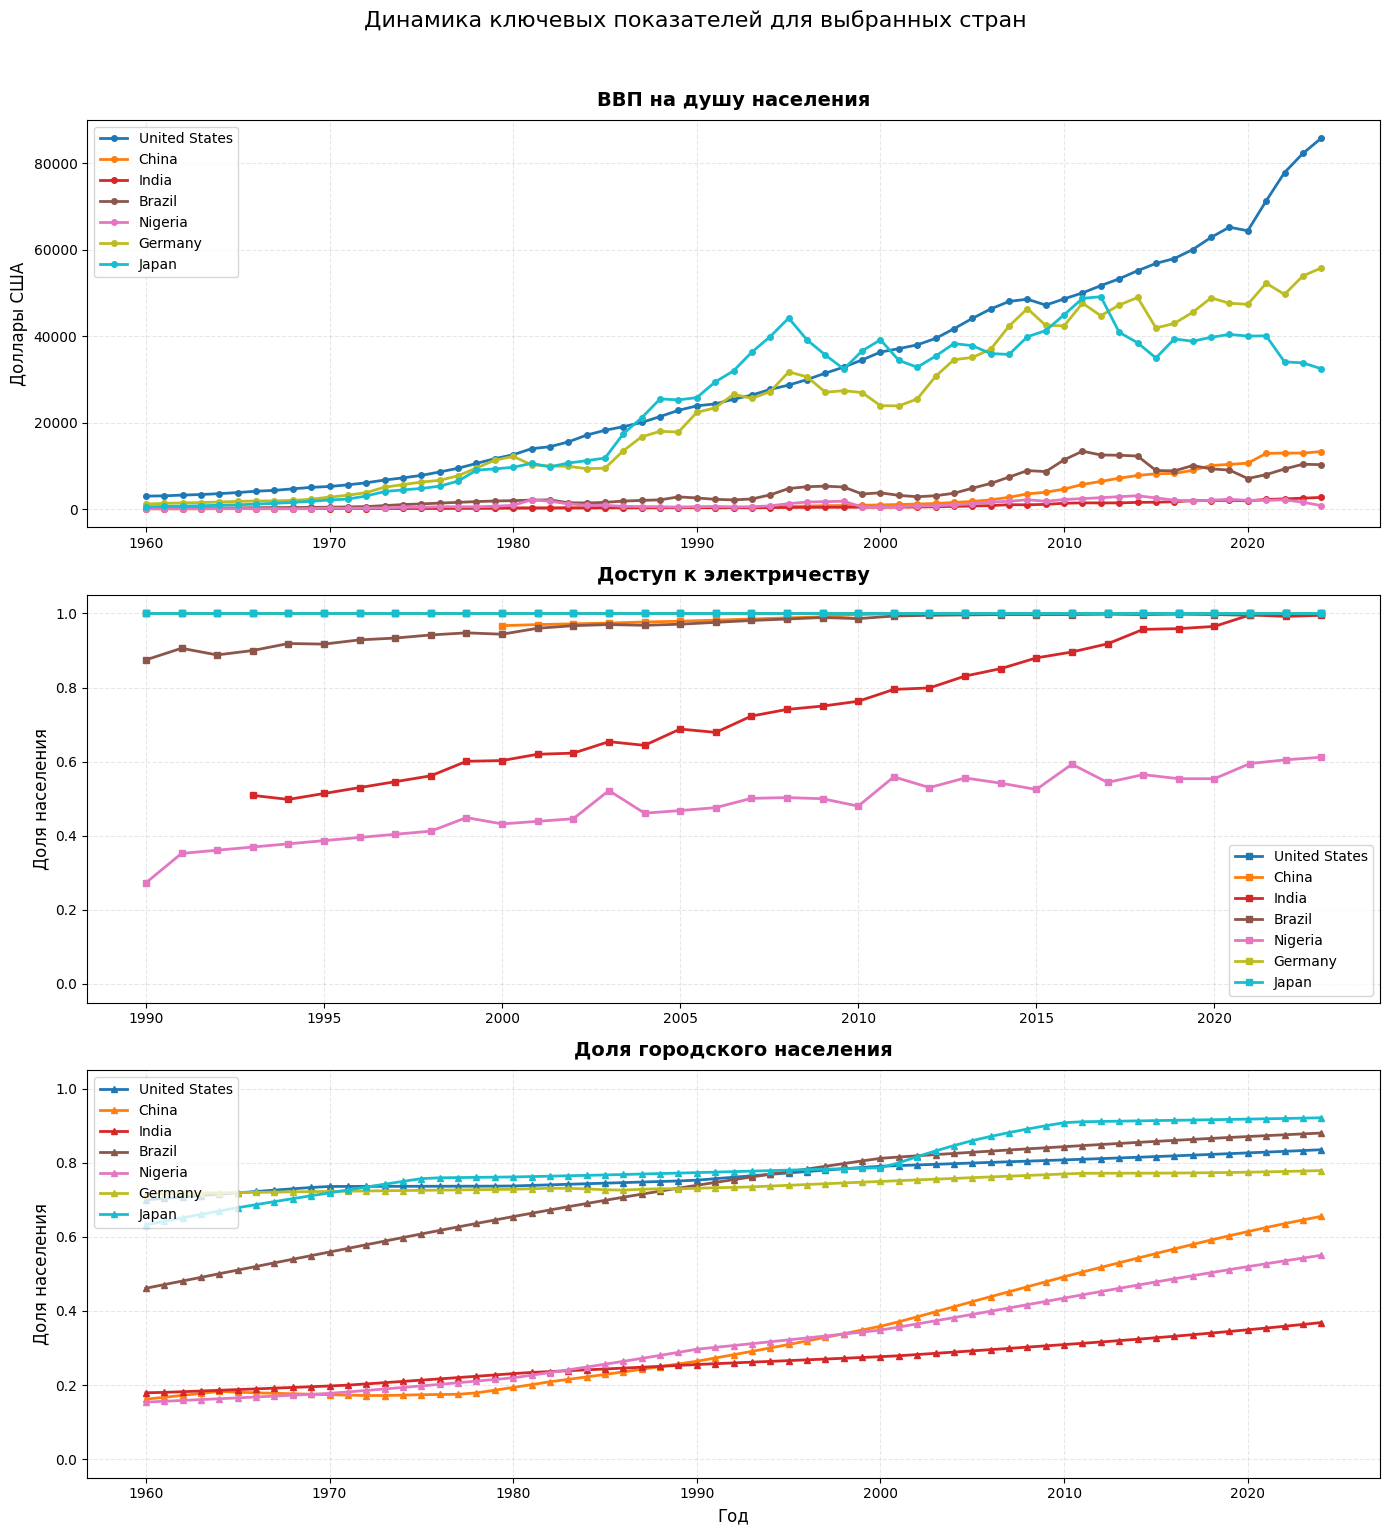

In [15]:
# Выбираем ключевые страны
key_countries = ['United States', 'China', 'India', 'Brazil', 'Nigeria', 'Germany', 'Japan']

# Создаем отдельные графики для каждого индикатора
fig, axes = plt.subplots(3, 1, figsize=(14, 15))
fig.suptitle('Динамика ключевых показателей для выбранных стран', fontsize=16, y=1.02)

# Цвета для стран
colors = plt.cm.tab10(np.linspace(0, 1, len(key_countries)))

# ===== 1. ВВП на душу населения =====
ax1 = axes[0]
indicator_gdp = 'GDP per capita (current US$)'

for country_idx, country in enumerate(key_countries):
    country_data = df_all_country[
        (df_all_country['country'] == country) & 
        (df_all_country['indicator'] == indicator_gdp)
    ].sort_values('year')
    
    if len(country_data) > 0:
        ax1.plot(country_data['year'], country_data['value'], 
                label=country, color=colors[country_idx], 
                linewidth=2, marker='o', markersize=4)

ax1.set_title('ВВП на душу населения', fontsize=14, fontweight='bold', pad=10)
ax1.set_ylabel('Доллары США', fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper left', fontsize=10)

# ===== 2. Доступ к электричеству (доли 0-1) =====
ax2 = axes[1]
indicator_elec = 'Access to electricity (% of population)'

for country_idx, country in enumerate(key_countries):
    country_data = df_all_country[
        (df_all_country['country'] == country) & 
        (df_all_country['indicator'] == indicator_elec)
    ].sort_values('year')
    
    if len(country_data) > 0:
        ax2.plot(country_data['year'], country_data['value'], 
                label=country, color=colors[country_idx], 
                linewidth=2, marker='s', markersize=4)

ax2.set_title('Доступ к электричеству', fontsize=14, fontweight='bold', pad=10)
ax2.set_ylabel('Доля населения', fontsize=12)  # Изменено!
ax2.set_ylim(-0.05, 1.05)  # Теперь от 0 до 1
# ИЛИ преобразовать в проценты для наглядности:
# ax2.set_ylim(-5, 105)
# ax2.set_ylabel('Процент населения', fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='lower right', fontsize=10)

# ===== 3. Доля городского населения (доли 0-1) =====
ax3 = axes[2]
indicator_urban = 'Urban population (% of total population)'

for country_idx, country in enumerate(key_countries):
    country_data = df_all_country[
        (df_all_country['country'] == country) & 
        (df_all_country['indicator'] == indicator_urban)
    ].sort_values('year')
    
    if len(country_data) > 0:
        ax3.plot(country_data['year'], country_data['value'], 
                label=country, color=colors[country_idx], 
                linewidth=2, marker='^', markersize=4)

ax3.set_title('Доля городского населения', fontsize=14, fontweight='bold', pad=10)
ax3.set_xlabel('Год', fontsize=12)
ax3.set_ylabel('Доля населения', fontsize=12)  # Изменено!
ax3.set_ylim(-0.05, 1.05)  # Теперь от 0 до 1
# ИЛИ преобразовать в проценты для наглядности:
# ax3.set_ylim(-5, 105)
# ax3.set_ylabel('Процент населения', fontsize=12)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

**ВВП на душу населения**
- стабильный рост у США и Германии
- у Японии стремительный рост до середины 90-х, потом боковой тренд (стагнация)
- у Бразилии рост до 2010-2011, потом стагнация
- у Китая рост с нулевых годов
- у Индии и Нигерии почти нет роста (у Индии, скорее всего, рост населения в том же темпе, что и рост экономики, поэтому ВВП на душу населения не растет)

**Доступ к электричеству, доля от населения**
- на графике "Доступ к электричеству" США, Германия и Япония слились в одну линию, т.к. у них на всем протяжении данных 100% доступ населения к электричеству - прямая линия в отметке 1.0 на графике.
- почти все выбранные для анализа страны достили 100% доступа населения к электричеству после 2020 года.
- Нигерия тоже уверенно растет в этом показателе, хотя до 100% еще далеко

**Доля городского населения**
- у США, Германии, Японии и Бразилии доля городского населения около или выше 80%
- у Китая выше 60%
- самая низкая из выбранных стран у Индии - около 40%

---

### 3.2 Сравнителный анализ ВВП на карте мира

На данном интерактивном графике можно посмотреть ВВП страны на душу населения, наведя курсор. Данные приведены за 2024 год.

In [16]:
# указываю рендер
pio.renderers.default = "notebook"

# проверяю, какие годы есть
years_with_data = df_all_country[
    df_all_country['indicator'] == 'GDP per capita (current US$)'
]['year'].unique()

# беру последний доступный год
selected_year = max(years_with_data)
print(f"Беру данные за {selected_year} год")

# фильтрую
gdp_data = df_all_country[
    (df_all_country['indicator'] == 'GDP per capita (current US$)') & 
    (df_all_country['year'] == selected_year)
]

print(f"Найдено {len(gdp_data)} стран")

# 4. Создаю карту
fig = px.choropleth(
    data_frame=gdp_data,
    locations='country_id',
    locationmode='ISO-3',
    color='value',
    hover_name='country',
    title=f'ВВП на душу населения ({selected_year} год)',
    color_continuous_scale='Viridis'  # более контрастная палитра
)

fig.show()

Беру данные за 2024 год
Найдено 183 стран


### 3.3 Динамика доступа к электричеству по группам стран с разным уровнем дохода

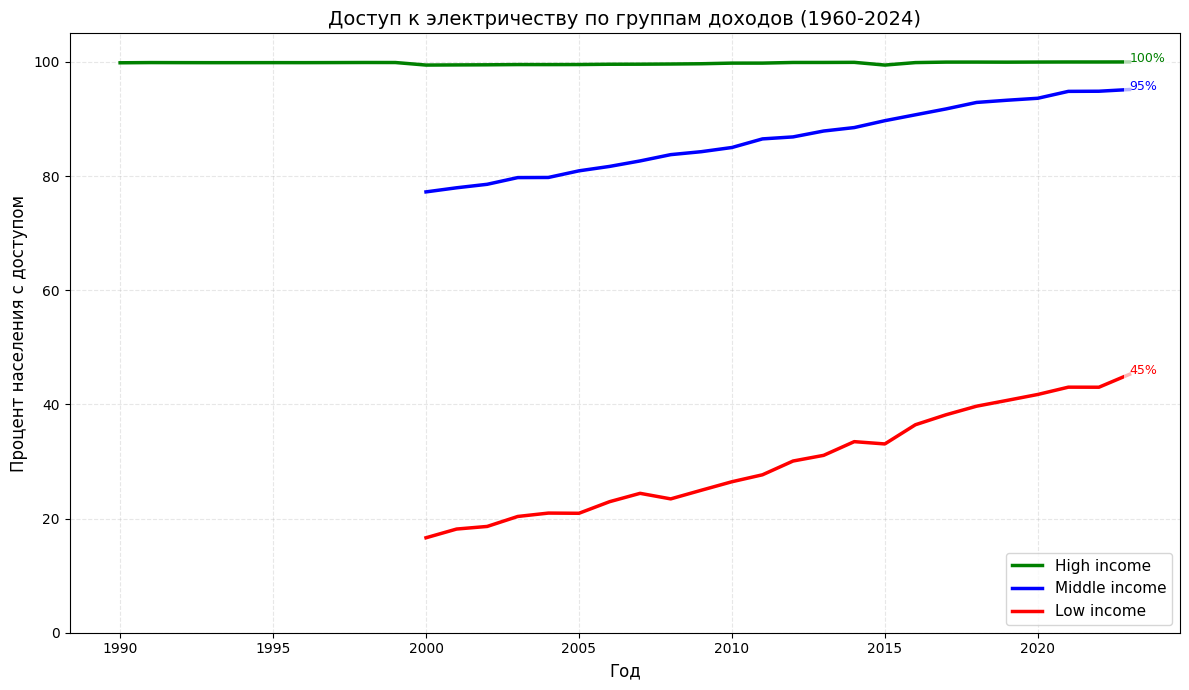

In [17]:
# Создаем график
plt.figure(figsize=(12, 7))

# Категории доходов и их цвета
income_groups = ['High income', 'Middle income', 'Low income']
colors = {'High income': 'green', 'Middle income': 'blue', 'Low income': 'red'}

# Для каждой группы рисуем линию
for group in income_groups:
    # Фильтруем данные по группе и показателю
    group_data = df_income_categories[
        (df_income_categories['country'] == group) & 
        (df_income_categories['indicator'] == 'Access to electricity (% of population)')
    ].sort_values('year')
    
    if len(group_data) > 0:
        # Данные в долях, переводим в проценты
        years = group_data['year']
        values = group_data['value'] * 100
        
        # Рисуем линию
        plt.plot(years, values, 
                label=group,
                color=colors[group],
                linewidth=2.5)
        
        # Подписываем последнюю точку
        last_year = years.iloc[-1]
        last_value = values.iloc[-1]
        plt.text(last_year, last_value, f'{last_value:.0f}%', 
                fontsize=9, color=colors[group],
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Настраиваем график
plt.title('Доступ к электричеству по группам доходов (1960-2024)', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Процент населения с доступом', fontsize=12)

# Ось Y от 0 до 100%
plt.ylim(0, 105)

# Сетка
plt.grid(True, alpha=0.3, linestyle='--')

# Легенда
plt.legend(loc='lower right', fontsize=11)

# Показываем график
plt.tight_layout()
plt.show()

Данные для групп Средний доход и Низкий доход есть только начиная с 2000 года.

- для стран с Высоким доходом - 100% доступ населения к электричеству на протяжении всех лет наблюдений
- для стран со Средним доходом видим рост с 77-78% в 2000г. до 95% в 2024г.
- для стран с Низким доходом видим рост с менее чем 20% в 2000г. до 45% в 2024г.

---

## Этап 4. Углубленный анализ

### 4.1 Корреляция показателей

Корреляционный анализ проведен для 9 показателей:
- ВВП на душу населения
- Доступ к электричеству, доля от населения
- Городское население, доля от популяции
- Затраты на образование, доля от ВВП
- Затраты на здравоохранение, доля от ВВП
- Детская смертность, на 1000 рождений
- Использование интернета населением на душу населения
- Потребление энергии на душу населения
- Кол-во научных публикаций на душу населения

Для построения матрицы корреляции сначала нахожу годы, для которых в данных есть значения для всех этих показателей и для большинства стран.

In [18]:
all_indicators = [
    'GDP per capita (current US$)',
    'Access to electricity (% of population)',
    'Urban population (% of total population)',
    'Government expenditure on education, total (% of GDP)',
    'Current health expenditure (% of GDP)',
    'Mortality rate, under-5 (per 1,000 live births)',
    'Individuals using the Internet (% of population)',
    'Energy use (kg of oil equivalent per capita)',
    'Sci. and tech. journal articles per capita'
]
# кол-во индикаторов в каждый год
years_with_all_indicators = (
    df_all_country[df_all_country['indicator'].isin(all_indicators)]
    .groupby('year')['indicator']
    .nunique()
    .reset_index()
)
# Годы, где все индикаторы присутствуют
years_with_all_indicators = years_with_all_indicators[
    years_with_all_indicators['indicator'] == len(all_indicators)
]['year'].tolist()

print("Годы с данными по всем индикаторам:", np.sort(years_with_all_indicators))


# Определяю годы с данными для большинства стран
# Сначала считаю количество уникальных стран по каждому году
country_counts_per_year = df_all_country.groupby('year')['country_id'].nunique()

# Определяю, сколько стран является "большинством"
# Например, возьму 70% от максимального числа стран в данных
max_countries = country_counts_per_year.max()
threshold = max_countries * 0.7

years_with_most_countries = country_counts_per_year[
    country_counts_per_year >= threshold
].index.tolist()

print("Годы с данными для большинства стран:", np.sort(years_with_most_countries))


# нахожу годы, которые содержат все индикаторы и большинство стран:
selected_years = list(set(years_with_all_indicators) & set(years_with_most_countries))
print("Годы с данными по всем индикаторам и для большинства стран:", np.sort(selected_years))

Годы с данными по всем индикаторам: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
Годы с данными для большинства стран: [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023 2024]
Годы с данными по всем индикаторам и для большинства стран: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]


Видно, что значения для всех показателей и для большинства стран в данных есть за период с 2000 по 2022 годы, без разрвывов в годах.

Для построения матрицы корреляции возьмем 2000, 2010 и 2022 годы.

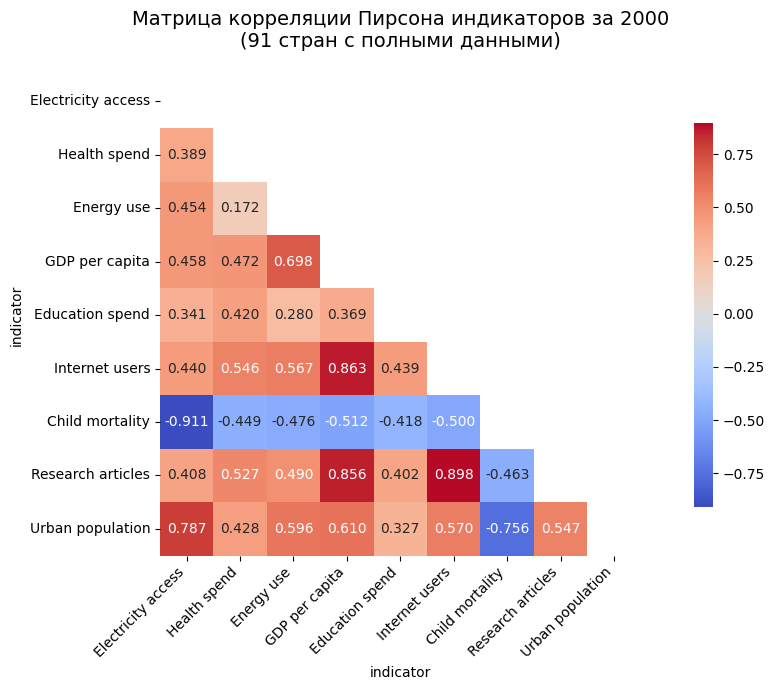

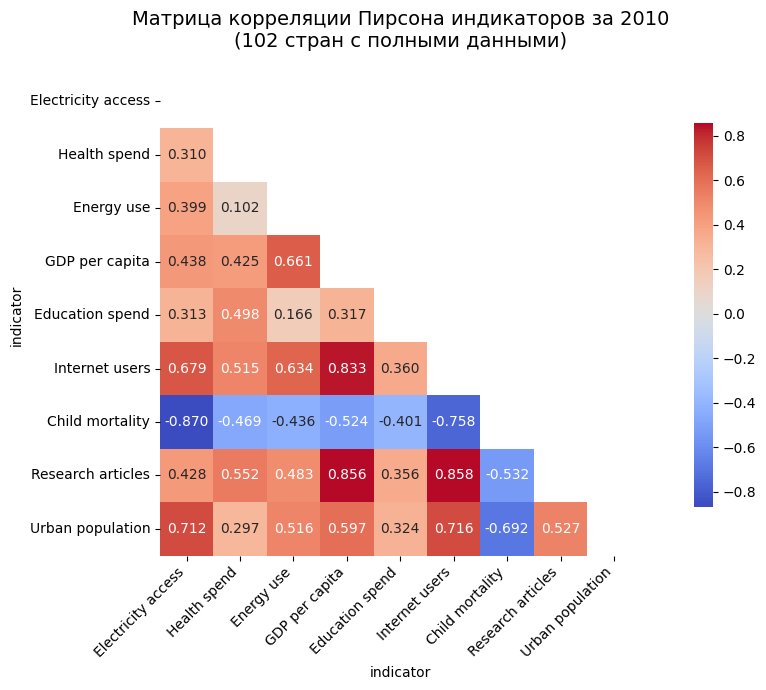

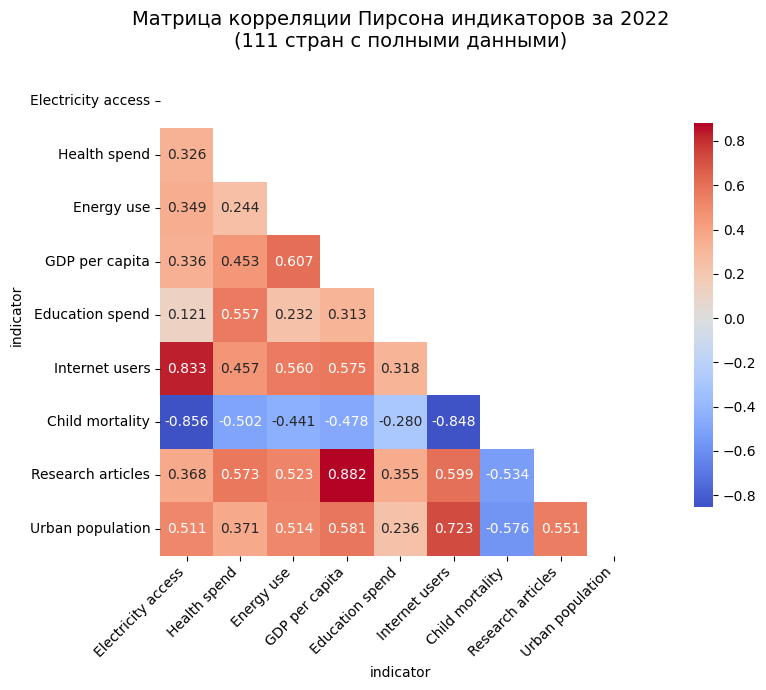

In [19]:
# Определенные годы
short_names = {
    'GDP per capita (current US$)': 'GDP per capita',
    'Access to electricity (% of population)': 'Electricity access',
    'Urban population (% of total population)': 'Urban population',
    'Government expenditure on education, total (% of GDP)': 'Education spend',
    'Current health expenditure (% of GDP)': 'Health spend',
    'Mortality rate, under-5 (per 1,000 live births)': 'Child mortality',
    'Individuals using the Internet (% of population)': 'Internet users',
    'Energy use (kg of oil equivalent per capita)': 'Energy use',
    'Sci. and tech. journal articles per capita': 'Research articles'
}

interest_pairs = [
    ('Internet users', 'Electricity access'),
    ('Internet users', 'GDP per capita'),
    ('Child mortality', 'Electricity access'),
    ('Research articles', 'GDP per capita'),
    ('Research articles', 'Internet users'),
    ('Urban population', 'Electricity access'),
    ('Urban population', 'Child mortality')
]

# Инициализация словаря для всех корреляций по годам
all_year_corrs = {pair: [] for pair in interest_pairs}

selected_years = [2000, 2010, 2022]

for year in selected_years:
    df_year = df_all_country[
        (df_all_country['year'] == year) &
        (df_all_country['indicator'].isin(all_indicators))
    ]
    pivot_df = df_year.pivot_table(
        values='value',
        index='country',
        columns='indicator',
        aggfunc='mean'
    )
    pivot_df = pivot_df.dropna()

    corr_matrix = pivot_df.corr(method='pearson')

    # Переименование индикаторов в матрице корреляции
    corr_matrix.rename(columns=short_names, index=short_names, inplace=True)

    for pair in interest_pairs:
        corr_value = corr_matrix.loc[pair[0], pair[1]]
        all_year_corrs[pair].append(corr_value)

    plt.figure(figsize=(11, 7))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        cmap='coolwarm',
        center=0,
        square=True,
        fmt='.3f',
        cbar_kws={"shrink": 0.8}
    )
    plt.title(f'Матрица корреляции Пирсона индикаторов за {year}\n'
              f'({len(pivot_df)} стран с полными данными)', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

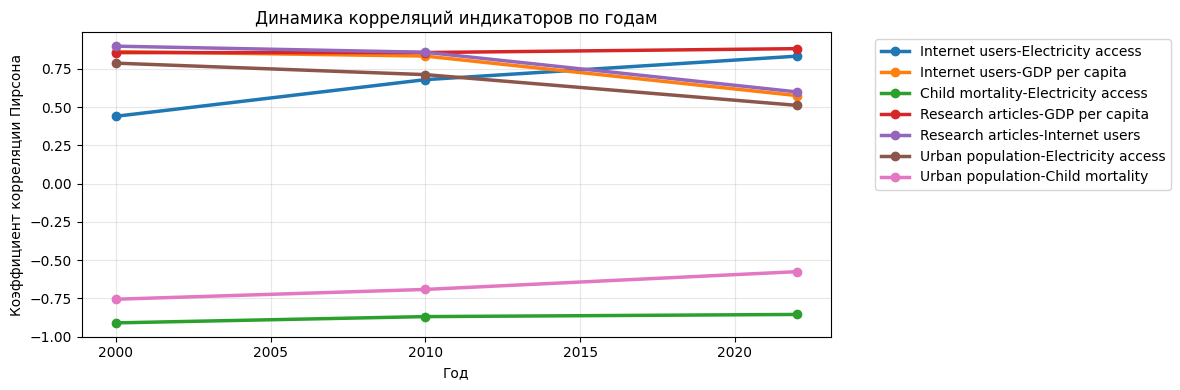

Динамика корреляций:
                                       2000   2010   2022
Internet users-Electricity access    0.440  0.679  0.833
Internet users-GDP per capita        0.863  0.833  0.575
Child mortality-Electricity access  -0.911 -0.870 -0.856
Research articles-GDP per capita     0.856  0.856  0.882
Research articles-Internet users     0.898  0.858  0.599
Urban population-Electricity access  0.787  0.712  0.511
Urban population-Child mortality    -0.756 -0.692 -0.576


In [20]:
# Создание DataFrame с динамикой корреляций
corr_dynamics = pd.DataFrame({
    f"{pair[0]}-{pair[1]}": corrs 
    for pair, corrs in all_year_corrs.items()
}, index=selected_years)

# Линейный график динамики
plt.figure(figsize=(12, 4))
for pair_name in corr_dynamics.columns:
    plt.plot(corr_dynamics.index, corr_dynamics[pair_name], 
             marker='o', linewidth=2.5, label=pair_name)

plt.xlabel('Год')
plt.ylabel('Коэффициент корреляции Пирсона')
plt.title('Динамика корреляций индикаторов по годам')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда справа
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Динамика корреляций:\n", corr_dynamics.T.round(3))

- Наблюдаем рост корреляции Использования интернета к Доступу к электричеству со слабой (0,44) в 2000г. до сильной (0,833) в 2022г. - скорее всего это связано с развитием самого интернета (в 2000 он был молод, только появился мобильный интернет)
- Наблюдается снижение корреляции Использования интернета к ВВП на душу населения от сильной (0,86) в 2000г. до средней (0,58) в 2022г. - интернет становится дешевле и доступнее, поэтому уже не так зависит от ВВП страны.
- Кол-во научных публикаций стабильно держит высокую корреляцию с ВВП (выше 0,85 все годы) - т.е. видим прямую зависимость развития науки от ВВП страны.
- Кол-во научных публикаций теряет корреляцию с использованием интернета с сильной (0,9) в 2000г. до средней (0,6) в 2022г. - это связано с падением корреляции пользования интернета к ВВП
- Наблюдаем снижение корреляции урбанизации к доступу к электричеству - скорее всего это связано с ростом урбанизации в развивающихся странах, где инфраструктура не успевает за ростом городов (например в Африке).
- Видим достаточно устойчивую сильную отрицательную корреляцию детской смертности к доступу к электричеству
- Урбанизация хоть и имеет отрицательную корреляцию с детской смертностью выше среднего, но видна положительная динамика этой корреляции: с -0,76 в 2000г. поднялась до -0,58 в 2022г.

### 4.2 Анализ взаимосвязей

Делаю график, показывающий взаимосвязи ВВП на душу населения (ось Х), доступа к элкетричеству (ось Y), численностью населения (размер точки) и уровнем дохода (цвет точки).

In [21]:
# Фильтруем нужные показатели и приводим к нужному виду
indicators = ['GDP per capita (current US$)', 'Access to electricity (% of population)', 'Population, total']
df_filtered = df[df['indicator'].isin(indicators)].copy()

# Получаем таблицу в формате pivot (страна, год, ВВП, электричество, население, доход)
df_plot = df_filtered.pivot_table(
    index=['country', 'year', 'country_id', 'income_level_name'], 
    columns='indicator', 
    values='value'
).reset_index().dropna()

# Переименовываем колонки для удобства
df_plot.columns = ['country', 'year', 'country_id', 'income_level_name', 
                   'electricity_access','gdp_per_capita', 'population']
df_plot['electricity_access'] = df_plot['electricity_access'] * 100 # перевожу в %

# Ограничиваем группы дохода
df_plot = df_plot[df_plot['income_level_name'].isin([
    'Low income', 'Upper middle income', 'High income', 'Lower middle income'
])]

print("Данные подготовлены. Строк:", len(df_plot))
df_plot.head()

Данные подготовлены. Строк: 6185


country  year country_id income_level_name  electricity_access  \
40  Afghanistan  2000        AFG        Low income                 4.4   
41  Afghanistan  2001        AFG        Low income                 9.3   
42  Afghanistan  2002        AFG        Low income                14.1   
43  Afghanistan  2003        AFG        Low income                19.0   
44  Afghanistan  2004        AFG        Low income                23.8   

    gdp_per_capita  population  
40         174.931  20130300.0  
41         138.707  20284300.0  
42         178.954  21378100.0  
43         198.871  22733000.0  
44         221.764  23560700.0

In [22]:
# Выбираем последний доступный год (или конкретный)
latest_year = df_plot['year'].max()
df_latest = df_plot[df_plot['year'] == latest_year]

# Порядок уровней дохода от высокого к низкому
income_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

color_map = {
    'High income': 'green',
    'Upper middle income': 'orange',  
    'Lower middle income': 'blue',
    'Low income': 'purple'  
}

fig = px.scatter(
    df_latest, 
    x='gdp_per_capita', 
    y='electricity_access',
    size='population',
    color='income_level_name',
    color_discrete_map=color_map,
    trendline="ols",
    hover_name='country',
    size_max=60,
    log_x=True,  # Логарифмическая шкала для ВВП
    category_orders={
        'year': sorted(df_plot['year'].unique()),
        'income_level_name': income_order 
    },
    title=f'ВВП на душу населения vs Доступ к электричеству, % ({latest_year})'
)

# Добавляем линию тренда
fig.add_hline(y=100, line_dash="dash", line_color="red", 
              annotation_text="100% электрификация")

fig.show()

Видно, что у стран с низким и ниже среднего доходами ярко выражен тренд на увеличение доступа к электричеству при росте ВВП.

Страны с высоким и выше среднего доходами уже близко или достигли 100% доступа населения к экетричеству. 

Также видим, что много стран с достаточно низким ВВП (от 2000 до 5000) имеют более 95% электрификации.

Этот же график, но в динамике по годам.

In [23]:
# Анимация по всем годам
fig_anim = px.scatter(
    df_plot, 
    x='gdp_per_capita', 
    y='electricity_access',
    size='population',
    color='income_level_name',
    color_discrete_map=color_map,
    trendline="ols",
    hover_name='country',
    size_max=60,
    animation_frame='year',
    animation_group='country',
    log_x=True,
    range_x=[100, 100000],  # Фиксируем шкалу
    range_y=[0, 120],
    category_orders={
        'year': sorted(df_plot['year'].unique()),
        'income_level_name': income_order  # Ключевой параметр!
    },
    title='Динамика ВВП и доступа к электричеству по странам'
)

fig_anim.show()

В динамике видно, что ВВП стран растет, а с ним и доступ населения к электричеству, и эта тенденция стабильна. Хотя для стран с доходм выше среднего линия тренда мноие годы смотрит вниз! Возможно, это влияние развивающихся стран, у которых ВВП растет сильно, но электрификация растет не так быстро (чуть выше 80% от численности населения) - примеры таких стран на графике: ЮАР, Ливия, Перу.

### 4.3 Кластеризация стран

Для кластеризации стран выбраны показатели:
- ВВП на душу населения
- Доступ к электричеству, доля от численности населения
- Городское население, доля от всего населения страны

Кластеризация проводится методом K-Means, кол-во кластеров выбрано 4.

In [24]:
# задаю индикаторы для кластеризации
indicators_for_kmeans = [
    'GDP per capita (current US$)',
    'Access to electricity (% of population)',
    'Urban population (% of total population)'
]

# --- Функция кластеризации для одного года -----------------------------------

def get_year_clusters(df_all_country: pd.DataFrame, year: int) -> pd.DataFrame:
    """
    Возвращает df с индексом country и колонками:
    [indicators_for_kmeans..., 'cluster', 'year'] для заданного года.
    Если данных нет или после очистки ничего не осталось — возвращает пустой df.
    """
    df_year = df_all_country[df_all_country['year'] == year]
    if df_year.empty:
        return pd.DataFrame()

    # pivot: страны × индикаторы
    df_pivot = df_year.pivot(
        index='country',
        columns='indicator',
        values='value'
    )

    # проверяем, что все индикаторы есть
    if not set(indicators_for_kmeans).issubset(df_pivot.columns):
        return pd.DataFrame()

    # отбор нужных индикаторов, обработка пропусков
    df_clean = df_pivot[indicators_for_kmeans] \
        .dropna(thresh=len(indicators_for_kmeans) - 1)
    df_clean = df_clean.fillna(df_clean.median())

    # удаление выбросов по z-score
    z_scores = np.abs(zscore(df_clean[indicators_for_kmeans]))
    df_no_outliers = df_clean[z_scores.max(axis=1) < 3].copy()
    if df_no_outliers.empty:
        return pd.DataFrame()

    # стандартизация и K-Means
    scaler = StandardScaler()
    X = scaler.fit_transform(df_no_outliers)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df_no_outliers.loc[:, 'cluster'] = kmeans.fit_predict(X)

    df_no_outliers['year'] = year
    return df_no_outliers

In [25]:
# ----- Функция визуализации кластеров ----------

def clusters_visualisation(df_no_outliers):    
    """
    Выводит на экран график scatterplot и медианную статистику по кластерам
    """
    fig = px.scatter(
        df_no_outliers.reset_index(),
        x=indicators_for_kmeans[0],
        y=indicators_for_kmeans[2],
        color='cluster',
        hover_name='country',
        size=indicators_for_kmeans[1],
        title=f'Кластеризация стран {df_no_outliers['year'].max()}',
        )
    fig.show()
    
    # вывожу медианные значения для кластеров
    cluster_profiles = df_no_outliers.groupby('cluster')[indicators_for_kmeans] \
        .median().round(2)
    print('\nМедианы показателей по кластерам:')
    display(cluster_profiles)
    

In [26]:
# смотрю кластеризацию за 2023 год
df_2023_clusters = get_year_clusters(df_all_country, 2023)
clusters_visualisation(df_2023_clusters)


Медианы показателей по кластерам:


indicator  GDP per capita (current US$)  \
cluster                                   
0                               1394.18   
1                              11004.75   
2                               4870.04   
3                              57266.30   

indicator  Access to electricity (% of population)  \
cluster                                              
0                                             0.55   
1                                             1.00   
2                                             1.00   
3                                             1.00   

indicator  Urban population (% of total population)  
cluster                                              
0                                              0.46  
1                                              0.77  
2                                              0.43  
3                                              0.88

**Кластер 3 — «Высокоразвитые постиндустриальные»**
- GDP per capita ≈ 57–64k — самый высокий среди всех кластеров.
- Access to electricity ≈ 1.00 — практически полный доступ.
- Urban population ≈ 0.85–0.88 — очень высокая урбанизация.

Типичные страны: развитые экономики ОЭСР, небольшие богатые страны, финансовые/сервисные центры.
Название: «Высокоразвитые постиндустриальные страны».

**Кластер 1 — «Страны среднего / относительно высокого дохода»**
- GDP per capita ≈ 11–15k — заметно ниже, чем у кластера 3, но существенно выше бедных кластеров.
- Access to electricity ≈ 0.99–1.00 — почти полный доступ.
- Urban population ≈ 0.77–0.78 — высокая, но чуть ниже, чем у кластера 3.

Это страны со сформированной инфраструктурой, но не «топ-богатые»: южная Европа, более развитые страны Латинской Америки, Восточная Европа, часть Азии.
Название: «Страны со средне-высоким уровнем дохода» или «индустриализированные развивающиеся».

**Кластер 2 — «Развивающиеся урбанизирующиеся»**
- GDP per capita ≈ 4.9–7.6k — средний/нижний средний доход.
- Access to electricity ≈ 0.96–1.00 — доступ почти полный, инфраструктура подтянута.
- Urban population ≈ 0.42–0.43 — урбанизация заметно ниже, чем в кластерах 1 и 3.

Это страны, где экономика растёт, инфраструктура уже есть, но структура ещё менее урбанизированная: крупные развивающиеся экономики, многие страны Азии, Латинской Америки, СНГ.
Название: «Страны с быстрорастущей экономикой / индустриализирующиеся».

**Кластер 0 — «Бедные / преимущественно аграрные»**
- GDP per capita ≈ 1.4–2.2k — самый низкий.
- Access to electricity ≈ 0.53–0.55 — у значимой части населения нет доступа.
- Urban population ≈ 0.46–0.47 — умеренная урбанизация (не совсем «деревня», но и далеко не города-кластеры 1/3).

Это страны с низким уровнем дохода, слабой инфраструктурой, значимой долей сельского населения: многие страны Африки к югу от Сахары, часть бедных стран Азии.
Название: «Аграрные / наименее развитые страны».

Посмотрим другие года - 2000, 2010

In [27]:
# смотрю кластеризацию за 2000 год
df_2000_clusters = get_year_clusters(df_all_country, 2000)
clusters_visualisation(df_2000_clusters)


Медианы показателей по кластерам:


indicator  GDP per capita (current US$)  \
cluster                                   
0                               3870.82   
1                                405.79   
2                              24303.45   
3                               1456.04   

indicator  Access to electricity (% of population)  \
cluster                                              
0                                             0.99   
1                                             0.18   
2                                             1.00   
3                                             0.94   

indicator  Urban population (% of total population)  
cluster                                              
0                                              0.74  
1                                              0.27  
2                                              0.81  
3                                              0.46

In [28]:
# смотрю кластеризацию за 2010 год
df_2010_clusters = get_year_clusters(df_all_country, 2010)
clusters_visualisation(df_2010_clusters)


Медианы показателей по кластерам:


indicator  GDP per capita (current US$)  \
cluster                                   
0                               9314.07   
1                                952.28   
2                              44968.20   
3                               4058.54   

indicator  Access to electricity (% of population)  \
cluster                                              
0                                             0.99   
1                                             0.31   
2                                             1.00   
3                                             0.97   

indicator  Urban population (% of total population)  
cluster                                              
0                                              0.74  
1                                              0.33  
2                                              0.84  
3                                              0.47

Видим, что с годами происходит сдвиг вправо - ВВП стран растет, а урбанизация растет в основном только в кластере "Высокоразвитые постиндустриальные" страны. Также увеличился размер точек, что говорит об увеличении доступа к элкетричеству даже в бедных странах.

---

Добавляю в основную таблицу сегментацию по кластерам по годам с 2000 по 2023 (в эти года есть данные для всех трех индикаторов, которые учавствуют в кластеризации). 

Полученную таблицу сохраняю в базу данных.

In [29]:
gdp_col = 'GDP per capita (current US$)' # по медиане этого показателя буду определять границы сегментов
years = range(2000, 2024)  # можно поменять диапазон при необходимости

# --- Функция: ранжирование кластеров и присвоение сегментов -------------------

def map_clusters_to_labels_by_gdp_min(df_year_clusters: pd.DataFrame) -> pd.DataFrame:
    """
    df_year_clusters: результат get_year_clusters (index='country').
    Возвращает копию df_year_clusters с колонкой 'cluster_label'.
    """
    # медиана GDP по каждому кластеру
    gdp_med = df_year_clusters.groupby('cluster')[gdp_col].median()

    # сортируем кластеры по медиане GDP (бедные → богатые)
    ranked = gdp_med.sort_values()  # index = cluster_id

    # cluster_id -> ранг (0 = беднейший кластер, 3 = богатейший)
    rank_map = {cl_id: rank for rank, cl_id in enumerate(ranked.index)}

    # ранг → человекочитаемый сегмент
    rank_to_label = {
        0: 'Аграрные / наименее развитые',
        1: 'Развивающиеся урбанизирующиеся',
        2: 'Страны среднего / относительно высокого дохода',
        3: 'Высокоразвитые постиндустриальные',
    }

    df = df_year_clusters.copy()
    df['cluster_rank'] = df['cluster'].map(rank_map)
    df['cluster_label'] = df['cluster_rank'].map(rank_to_label)

    return df


# --- Основной цикл по годам: получаем сегменты для country–year --------------

cluster_labels_all_years = [] # собирает список из датафреймов по годам

for year in years:
    df_year_clusters = get_year_clusters(df_all_country, year)

    if df_year_clusters.empty:
        continue  # нет данных / ничего не осталось после очистки

    df_labeled = map_clusters_to_labels_by_gdp_min(df_year_clusters)

    # переносим индекс country в колонку для мерджа
    df_labeled = df_labeled.reset_index()  # теперь есть колонка 'country'

    # оставляем только ключи и сегмент
    cluster_labels_all_years.append(
        df_labeled[['country', 'year', 'cluster_label']]
    )

# объединяем по всем годам
if cluster_labels_all_years:
    df_clusters_all = pd.concat(cluster_labels_all_years, ignore_index=True) # объединет все датафреймы в списке в один датафрейм вертикально
else:
    df_clusters_all = pd.DataFrame(columns=['country', 'year', 'cluster_label']) # если список пустой, создает пустой датафрейм с нужными колонками

# --- Мерджим с исходной длинной таблицей -------------------------------------

df_all_country_with_segmentation = df_all_country.merge(
    df_clusters_all,
    on=['country', 'year'],
    how='left')


In [30]:
df_all_country_with_segmentation.sample(5)

country  \
60247              Costa Rica   
26214  British Virgin Islands   
67966                  Panama   
19624        Marshall Islands   
38055      Dominican Republic   

                                               indicator  year        value  \
60247       Energy use (kg of oil equivalent per capita)  2016  1001.150000   
26214  Government expenditure on education, total (% ...  2005     0.030463   
67966         Sci. and tech. journal articles per capita  2016     0.000038   
19624           Urban population (% of total population)  1964     0.412140   
38055    Mortality rate, under-5 (per 1,000 live births)  1999    41.000000   

      country_id    income_level_name  \
60247        CRI          High income   
26214        VGB          High income   
67966        PAN          High income   
19624        MHL  Upper middle income   
38055        DOM  Upper middle income   

                                        cluster_label  
60247  Страны среднего / относительно высокого дохода  
26214                  Развивающиеся урбанизирующиеся  
67966  Страны среднего / относительно высокого дохода  
19624                                             NaN  
38055                                             NaN

In [33]:
# сохраняю в базу данных
try:
    df_all_country_with_segmentation.to_sql(
        name="all_country_with_segmentation",
        con=engine,
        if_exists='replace',
        index=False,
        method='multi'
    )
except Exception as e:
    print(f"Ошибка при сохранении: {e}")

## Итоги

### Подтверждение ключевой гипотезы:

Гипотеза подтверждена: существует сильная положительная корреляция между уровнем экономического развития страны (ВВП на душу населения) и уровнем человеческого развития.

**Доказательства:**
- ВВП ↔ Доступ к электричеству: У стран с высоким доходом 100% доступ, с низким — лишь 45%
- ВВП ↔ Научные публикации: Стабильно высокая корреляция (>0.85) — наука напрямую зависит от экономики
- ВВП ↔ Интернет-пользователи: Сильная корреляция в 2000-х (0.86), снизилась до средней (0.58) — интернет стал доступнее
- ВВП ↔ Расходы на образование/здравоохранение: Прямая зависимость, но со снижением в кризисы

**Как менялась зависимость:**
- 1990-2000: Сильная зависимость всех социальных индикаторов от ВВП
- 2000-2010: Ослабление связи для базовых услуг (электричество становится доступнее)
- 2010-2023: Интернет и технологии перестают быть привилегией богатых стран

### Подтверждение альтернативной гипотезы:

Гипотеза подтверждена: существует комплексная взаимосвязь экономического роста, потребления ресурсов и социального прогресса.

**Треугольник развития:**
1. Экономика (ВВП) → Инфраструктура (электричество) → Социальный прогресс (урбанизация, образование)
2. **Обратные связи:** Урбанизация стимулирует экономику, образование повышает производительность

**Ключевые инсайты:**
- **Доступ к базовой инфраструктуре (электричеству) может быть достигнут и при низком ВВП**, что демонстрируют:
    -  Индия (99,5\% при 2,500\$ ВВП)
    -  Вьетнам (99,9\% при 4,000\$)
    -  Шри-Ланка (100\% при 3,400\$)
- **Урбанизационный переход**: при ~10,000\$ ВВП урбанизация превышает 70%
- **Научный скачок**: при >15,000\$ ВВП резко растут научные публикации на душу населения

### ОСНОВНЫЕ ТРЕНДЫ ЗА 30 ЛЕТ:
1. **Конвергенция по базовым услугам:**
- **Электричество**: Разрыв сократился с 80% до 55% между богатыми и бедными странами
- **Интернет**: Из роскоши стал массовым сервисом (корреляция с ВВП упала с 0.86 до 0.58)

2. **Дивергенция по продвинутым индикаторам:**
- **Наука**: Разрыв увеличивается (сильная корреляция с ВВП сохраняется)
- **Качество жизни**: Разрыв в образовании и здравоохранении остается значительным

3. **Региональные паттерны:**
- **Африка южнее Сахары**: Застряла в "ловушке бедности" (ВВП <3,000$, доступ к электричеству ~50%)
- **Азия**: Быстрая конвергенция (Китай, Вьетнам, Индия)
- **Латинская Америка**: Средняя группа с хорошей инфраструктурой, но экономическими проблемами
- **Развитые страны**: Достигли "плато" по базовым индикаторам, фокус на качестве услуг

### 4 Кластера стран (результат кластеризации):
1. **Постиндустриальные лидеры**: ВВП 57-64к\$, 100% электричество, 85%+ урбанизация
2. **Средне-высокие доходы**: ВВП 11-15к\$, почти 100% электричество
3. **Развивающиеся урбанизирующиеся**: ВВП 5-8к\$, доступ к электричеству 96-100%, урбанизация 42%
4. **Бедные аграрные**: ВВП 1.4-2.2к\$, доступ к электричеству 53-55%

### Тревожные тенденции:
- Снижение расходов на образование с 2005 года (максимум сместился с 4% до 3% ВВП)
- Замедление конвергенции после 2010 года (глобализация замедлилась)
- Африканская ловушка: Страны южнее Сахары не могут выйти из группы 4

### Эволюция взаимосвязей:
- 1990-е: Простая линейная зависимость "богатство → развитие"
- 2000-е: Начало комплексных взаимосвязей
- 2010-2023: Сеть взаимозависимостей с пороговыми эффектами и обратными связями

### ГЛАВНЫЙ ВЫВОД:

**Экономический рост — необходимое, но недостаточное условие для человеческого развития - базовые блага распространяются, но сложные системы остаются привилегией богатых стран.**. 

После достижения ВВП ~7,000$ на душу начинают работать сложные обратные связи: инфраструктура стимулирует экономику, образование повышает инновации, а институты определяют эффективность использования ресурсов.